<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод:" data-toc-modified-id="Промежуточный-вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучим-Логистическую-Регрессию" data-toc-modified-id="Обучим-Логистическую-Регрессию-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучим Логистическую Регрессию</a></span></li><li><span><a href="#Обучим-Случайный-лес-кроссвалидацией-по-сетке-гиперпараметров" data-toc-modified-id="Обучим-Случайный-лес-кроссвалидацией-по-сетке-гиперпараметров-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучим Случайный лес кроссвалидацией по сетке гиперпараметров</a></span></li><li><span><a href="#Обучим-модель-CatBoost" data-toc-modified-id="Обучим-модель-CatBoost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучим модель CatBoost</a></span></li><li><span><a href="#Проверим-на-тесте-работу-лучшей-модели---Случайный-лес,-CatBoost-возможно-я-недостаточно-настроил,-оказался-незначительно-хуже" data-toc-modified-id="Проверим-на-тесте-работу-лучшей-модели---Случайный-лес,-CatBoost-возможно-я-недостаточно-настроил,-оказался-незначительно-хуже-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверим на тесте работу лучшей модели - Случайный лес, CatBoost возможно я недостаточно настроил, оказался незначительно хуже</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [5]:
!pip install -q transformers catboost

In [6]:
# Импортируем необходимые библиотеки
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    f1_score)
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
import os
import torch
import transformers
from tqdm import notebook
from sklearn.metrics import accuracy_score
from transformers import AutoModel, AutoTokenizer 
from catboost import CatBoostClassifier

In [7]:
# Загрузим данные:

df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [8]:
# Посмотрим общую информацию о Дата Фрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [9]:
# Посмотрим первые 5 строк Дата Фрейма
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
# Посмотрим на наличие дубликатов строк
df.duplicated().sum()

0

In [11]:
# Добавим столбец о длинне сообщений
df['text_len'] = df['text'].apply(lambda x:len(x))

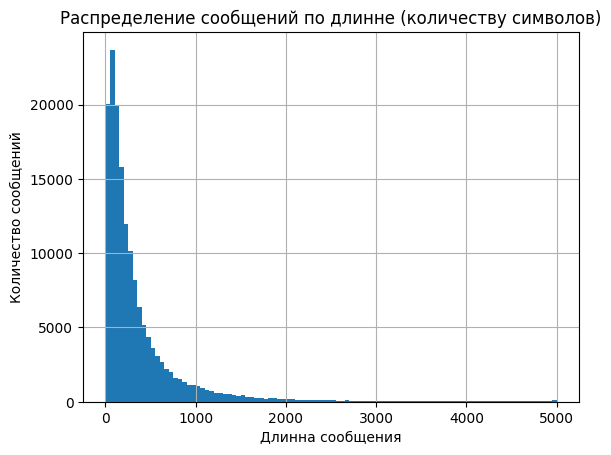

In [12]:
# Посмотрим на гистограмму распределения значений длины сообщений
df['text_len'].hist(bins=100)
plt.title("Распределение сообщений по длинне (количеству символов)")
plt.xlabel('Длинна сообщения')
plt.ylabel('Количество сообщений')
plt.show();  

In [13]:
# Описание длинны
df['text_len'].describe()

count    159292.000000
mean        393.691303
std         590.111825
min           5.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_len, dtype: float64

In [14]:
# Удалим лишний столбец
df = df.drop(['text_len'], axis=1)

In [15]:
df = df.drop('Unnamed: 0', axis=1).reset_index(drop='first')

In [16]:
# Проверим удаление
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [17]:
# Посмотрим на баланс классов
df['toxic'].mean()

0.10161213369158527

In [18]:
# Посмотрим на баланс классов
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [19]:
# В Google Colab появлялся пропуск в ДатаФрейме
df = df.dropna().reset_index(drop='first')
df.isna().sum()

text     0
toxic    0
dtype: int64

In [20]:
# Загрузим модель БЕРТ обученную на токсиных текстах

# Define the model repo
model_name = "unitary/toxic-bert" 

# Download pytorch model
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<b>Далее не запускал код т.к. это затратно по времени, проверял в Google Colab</b>

In [21]:
# Сделаем выборку на 600 примеров
_, df_sample = train_test_split(df,
 test_size=600,
 stratify=df['toxic'],
 random_state=12345)
 
print(df_sample.shape)
print('Баланс классов:', df_sample['toxic'].mean())

(600, 2)
Баланс классов: 0.10166666666666667


In [22]:
# Проверим
df_sample.head()

,text,toxic
33057,I can't believe that you have yet to object to...,0
16309,Complaint posted on Wikipedia:Administrators' ...,0
148418,Well \n\nThanks for your well-pointed assertio...,0
32744,America \n\nThey have Saturday morning cartoon...,0
35549,From the third party PoV - they'd be peeved th...,0


In [23]:
# Преобразуем текст в номера токенов из словаря методом encode()
tokenized = df_sample['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, padding='max_length', truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
# Применим метод padding (англ. «отступ»), чтобы после токенизации длины исходных текстов в корпусе были равными
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [24]:
# Подключим GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [25]:
# Преобразуем данные в формат тензоров (англ. tensor) — многомерных векторов в библиотеке torch
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
# Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
# Соберём все эмбеддинги в матрицу признаков вызовом функции concatenate()
features = np.concatenate(embeddings)

In [27]:
# Выделим тестовую выборку
features_train, features_test, target_train, target_test = train_test_split(features,
 df_sample['toxic'],
 test_size=150,
 stratify=df_sample['toxic'],
 random_state=12345)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)
print('Баланс классов:', target_train.mean(), target_test.mean())

(450, 768) (150, 768) (450,) (150,)
Баланс классов: 0.10222222222222223 0.1


### Промежуточный вывод:
Сделали выборки из 600 сообщений, для ускорения процесса. Пребразовали в токены и ограничили их длинну, чтобы модель BERT заработала. Получили итоговую матрицу Эмбэдингов. Признаки готовы к обучению и предсказанию.

## Обучение

### Обучим Логистическую Регрессию

In [28]:
# Сделаем метрику
f1 = make_scorer(f1_score)

In [29]:
# Обучим Логистическую регрессию и посмотрим на результат
model = LogisticRegression()

In [30]:
%%time
# Расчет значений на кросвалидации
scores = cross_val_score(model, features_train, target_train, cv=5, n_jobs=-1, verbose=10, scoring=f1)
final_score = pd.Series(scores).mean()
print('Средняя оценка качества модели F1:', final_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Средняя оценка качества модели F1: 0.9459629465821416
CPU times: user 63.1 ms, sys: 101 ms, total: 164 ms
Wall time: 2.61 s


In [31]:
%%time
# Посмотрим как справится конвеер с данными
pipe = make_pipeline(StandardScaler(), LogisticRegression())

scores = cross_val_score(pipe, features_train, target_train, cv=5, n_jobs=-1, verbose=10, scoring=f1)
final_score = pd.Series(scores).mean()

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

print('Средняя оценка качества модели F1:', final_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0681s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Средняя оценка качества модели F1: 0.9554867561059511
CPU times: user 21.1 ms, sys: 2.28 ms, total: 23.4 ms
Wall time: 260 ms


### Обучим Случайный лес кроссвалидацией по сетке гиперпараметров

In [43]:
# параметры для GridSearchCV
parametrs = { 
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': range (1, 150, 10),
              'max_depth': range (1, 150, 10) }

In [44]:
# Поиск лучших гипер-параметров 
rfc = RandomForestClassifier(class_weight='balanced')
grid_rfc = GridSearchCV(rfc, parametrs, cv=5, n_jobs=-1, verbose=10, scoring='f1')
grid_rfc.fit(features_train, target_train)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 150, 10),
                         'n_estimators': range(1, 150, 10)},
             scoring='f1', verbose=10)

In [45]:
grid_rfc.best_params_

{'criterion': 'log_loss', 'max_depth': 11, 'n_estimators': 21}

In [49]:
grid_rfc.best_score_

0.966013071895425

### Обучим модель CatBoost

In [46]:
%%time
# Построим модель CatBoostClassifier

model_cat = CatBoostClassifier(loss_function='Logloss', verbose=10,  custom_metric= 'F1') 
param_search = {'learning_rate': [0.1,  0.3],
        'depth': [6, 8],
        'iterations': [100]}

gsearch_cat = GridSearchCV(estimator=model_cat, 
                       cv=5, 
                       param_grid=param_search,  
                       scoring=f1)

CPU times: user 153 µs, sys: 14 µs, total: 167 µs
Wall time: 173 µs


In [47]:
%%time
# Обучим модель
gsearch_cat.fit(features_train, target_train)    
print(gsearch.best_score_)

0:	learn: 0.5132083	total: 185ms	remaining: 18.3s
10:	learn: 0.0514641	total: 1.51s	remaining: 12.3s
20:	learn: 0.0149374	total: 3.59s	remaining: 13.5s
30:	learn: 0.0070857	total: 5.49s	remaining: 12.2s
40:	learn: 0.0045276	total: 6.78s	remaining: 9.76s
50:	learn: 0.0032286	total: 8.09s	remaining: 7.77s
60:	learn: 0.0024822	total: 9.38s	remaining: 6s
70:	learn: 0.0020309	total: 10.7s	remaining: 4.36s
80:	learn: 0.0017007	total: 12s	remaining: 2.81s
90:	learn: 0.0014731	total: 13.3s	remaining: 1.31s
99:	learn: 0.0013237	total: 14.5s	remaining: 0us
0:	learn: 0.5152412	total: 170ms	remaining: 16.9s
10:	learn: 0.0493087	total: 2.33s	remaining: 18.8s
20:	learn: 0.0153164	total: 4.1s	remaining: 15.4s
30:	learn: 0.0077785	total: 5.4s	remaining: 12s
40:	learn: 0.0050484	total: 6.7s	remaining: 9.64s
50:	learn: 0.0034688	total: 7.99s	remaining: 7.68s
60:	learn: 0.0026949	total: 9.3s	remaining: 5.94s
70:	learn: 0.0022051	total: 10.6s	remaining: 4.33s
80:	learn: 0.0018677	total: 11.9s	remaining: 2

In [48]:
gsearch_cat.best_params_

{'depth': 8, 'iterations': 100, 'learning_rate': 0.3}

### Проверим на тесте работу лучшей модели - Случайный лес, CatBoost возможно я недостаточно настроил, оказался незначительно хуже

In [39]:
%%time
# Посмотрим на результат метрики
from sklearn.metrics import classification_report
pred = grid_rfc.best_estimator_.predict(features_test)
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       135
           1       0.83      1.00      0.91        15

    accuracy                           0.98       150
   macro avg       0.92      0.99      0.95       150
weighted avg       0.98      0.98      0.98       150

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 13.5 ms


In [40]:
%%time
# Получим предсказание
pred = grid_rfc.best_estimator_.predict(features_test)
print('F1 метрика лучшей модели:', f1_score(target_test, pred))

F1 метрика лучшей модели: 0.9090909090909091
CPU times: user 8.67 ms, sys: 827 µs, total: 9.5 ms
Wall time: 9.98 ms


## Выводы

Предобработку текстов я не проводил. Проверили пропуски и дубликаты. Средняя длина сообщений 393 символа, максимальная длинна 5000 символов. Сделали выборки из 600 сообщений, для ускорения процесса. Пребразовали в токены и ограничили их длинну, чтобы модель BERT заработала. Получили итоговую матрицу Эмбэдингов. 

<p>Провели обучение разных моделей и получили следующие результаты на обучающей выборке:</p>

| Модель | Показатель F1|
| --- | --- |
| Логистической регрессия | 0.9459 |
| Логистической регрессия Pipeline | 0.9554 | 
| Случайный лес | 0.9660 |
| CatBoost Regressor | 0.9632 |

Лучший результат, от модели Случайного леса - F1 метрика лучшей модели: 0.9090909090909091
Работа в ГУГЛCOLAB
https://colab.research.google.com/drive/1EuVKONpoghtmZSUJZwy9x63ea8aha6G6#scrollTo=rs1rLAYJPRv5 

Как видно из результатов, Лучший результат показала модель - Логистической регрессия Pipeline. 